In [1]:
from sentence_transformers import SentenceTransformer
import random
import nltk
import dspy
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import pipeline
import re
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib
import os
import random
from sklearn.preprocessing import normalize
import colorcet as cc

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def create_category_string(category, dictionary, n=None):
    string = f"{category}: "

    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            if category == 'characters' and n is not None:
                category_data = category_data[:n]
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name':
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "

    return string.strip()

def transform_dict_to_strings(data, n=None):
    result = {}

    for category in data:
        result[category] = create_category_string(category, data, n=n)

    return result

def transform_dict_to_single_string(data, n=None):
    parts = []

    for category in data:
        parts.append(create_category_string(category, data, n=n))

    return " ".join(parts).strip()


In [3]:
class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [4]:
def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings


def get_dense_similarity(query_vector, candidate_vectors):
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    return np.dot(candidate_vectors, query_vector.T).flatten()

def get_relevance_scores(i, labels, index):
    matching_label = labels[i]

    query_vector = index[i].reshape(1, -1)
    similarities = get_dense_similarity(query_vector, index).flatten()

    relevance_scores = np.array([1 if x == matching_label else 0 for x in labels])
    similarity_scores = similarities

    mask = np.arange(len(labels)) != i

    relevance_scores = relevance_scores[mask]
    similarity_scores = similarity_scores[mask]

    return relevance_scores.tolist(), similarity_scores.tolist()


def calculate_mean_ndcg_score(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    scores = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)
        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)
        #k = relevance_scores.sum()
        k = None
        scores.append(ndcg_score([relevance_scores], [similarity_scores], k=k))

    return np.mean(scores)


def calculate_mean_recall(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    recalls = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)

        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)

        k = relevance_scores.sum()
        if k == 0:
            continue

        sorted_indices = np.argsort(-similarity_scores)

        top_k_indices = sorted_indices[:k]

        top_k_relevance = relevance_scores[top_k_indices]

        recall = top_k_relevance.sum() / k
        recalls.append(recall)

    if len(recalls) == 0:
        return 0.0
    return np.mean(recalls)





In [5]:
def min_max_scale(arr):
    arr = np.array(arr)
    min_val = arr.min()
    max_val = arr.max()
    if max_val == min_val:
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)


def get_dense_similarity(query_vec, matrix):
    query_vec = np.array(query_vec).reshape(1, -1)
    return cosine_similarity(query_vec, matrix)[0]



#def transform_dict_to_strings(d):
    #return {k: ' '.join(str(vv) for vv in v) if isinstance(v, list) else str(v) for k, v in d.items()}


def get_similarity_scores_from_embeddings(df, index, keys):
    keys.append("overall")
    similarities_by_key = {}

    for key in keys:
        embeddings = np.stack(df[f'embedding_{key}'].values)
        target_embedding = embeddings[index]
        similarities = get_dense_similarity(target_embedding, embeddings)
        similarities_by_key[key] = min_max_scale(similarities)

    all_similarities = np.zeros_like(next(iter(similarities_by_key.values())))

    return similarities_by_key


def make_spider(df, plot_idx, title, color, total_plots, overall_score, plots_per_row=5):
    categories = list(df.columns)[1:]
    if 'overall' in categories:
        categories.remove('overall')
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    row_idx = plot_idx // plots_per_row
    col_idx = plot_idx % plots_per_row
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row
    n_cols = min(plots_per_row, total_plots)

    ax = plt.subplot(n_rows, n_cols, plot_idx + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='black', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    values = df.loc[plot_idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    wrapped_title = "\n".join(title[i:i + 20] for i in range(0, len(title), 20))
    plt.title(wrapped_title, size=18, color=color, y=1.08)

    ax.text(0.5, 0.5, f"{overall_score:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=24, fontweight='bold', color=color)


def visualize_similarities(df, model, target_index, top_n=4, plots_per_row=5, ascending=False, exclude_self=False, exclude_keys=None):
    embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

    if exclude_keys is None:
        exclude_keys = []

    if not embedding_cols:
        df, keys = embed_elements(df, model)
    else:
        keys = [col.replace("embedding_", "") for col in embedding_cols 
                if col.replace("embedding_", "") not in exclude_keys and col != "embedding_overall"]

    similarities_by_key = get_similarity_scores_from_embeddings(df, index=target_index, keys=keys)

    overall_similarities = similarities_by_key["overall"]

    sorted_indices = np.argsort(overall_similarities)
    if not ascending:
        sorted_indices = sorted_indices[::-1]

    title_to_exclude = df.iloc[target_index]["title"] if exclude_self else None

    filtered_indices = []
    for i in sorted_indices:
        if exclude_self and df.iloc[i]["title"] == title_to_exclude:
            continue
        if not exclude_self and i == target_index:
            continue 
        filtered_indices.append(i)
        if len(filtered_indices) == top_n:
            break

    rows = []
    for i in filtered_indices:
        title = f"{df.iloc[i]['title']} ({df.iloc[i]['language']})"
        data_row = {'group': title}
        for key in keys:
            data_row[key] = similarities_by_key[key][i]
        data_row['overall'] = overall_similarities[i]
        rows.append(data_row)

    query_title = f"{df.iloc[target_index]['title']} ({df.iloc[target_index]['language']})"
    query_row = {'group': f"Query: {query_title}"}
    for key in keys:
        query_row[key] = similarities_by_key[key][target_index]
    query_row['overall'] = overall_similarities[target_index]
    rows.insert(0, query_row)

    plot_data = pd.DataFrame(rows)

    my_dpi = 96
    width_per_plot = 500
    height_per_plot = 500
    total_plots = len(plot_data.index)
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row

    fig_width = width_per_plot * min(plots_per_row, total_plots) / my_dpi
    fig_height = height_per_plot * n_rows / my_dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=my_dpi)
    base_titles = plot_data['group'].apply(lambda x: x.replace('Query: ', '').split(' (')[0])
    unique_titles = base_titles.unique()
    title_to_color_idx = {title: i for i, title in enumerate(unique_titles)}

    my_palette = cc.glasbey_dark  

    for plot_idx in range(total_plots):
        base_title = base_titles.iloc[plot_idx]
        color_idx = title_to_color_idx[base_title]
        color = my_palette[color_idx]  
    
        make_spider(df=plot_data, plot_idx=plot_idx, title=plot_data['group'][plot_idx],
                    color=color, total_plots=total_plots,
                    overall_score=plot_data.loc[plot_idx, 'overall'],
                    plots_per_row=plots_per_row)
    
    plt.tight_layout()
    plt.savefig("similarity_radar_plots.png", dpi=my_dpi, bbox_inches='tight')
    plt.show()


In [6]:
def embed_elements(df, model):
    transformed_data = []
    key_set = set()

    for row in df.itertuples(index=False):
        element = json.loads(row.extracted_elements)
        element['full_summary'] = row.unpacked_summary # add a full summary embedding
        transformed = transform_dict_to_strings(element, n=5)
        transformed_data.append(transformed)
        key_set.update(transformed)

    transformed_df = pd.DataFrame(transformed_data)

    embedding_arrays = {}
    for key in key_set:
        texts = transformed_df[key].tolist()
        embeddings = model.encode(texts, show_progress_bar=False)
        normalized_embeddings = normalize(np.array(embeddings), norm='l2')
        df[f'embedding_{key}'] = list(normalized_embeddings)
        embedding_arrays[key] = normalized_embeddings

    all_embeddings = np.stack([embedding_arrays[key] for key in key_set], axis=1)
    mean_embeddings = np.mean(all_embeddings, axis=1)
    df["embedding_overall"] = list(normalize(mean_embeddings, norm='l2'))

    return df, list(key_set)


In [7]:
class SimpleAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64, print_weights = False):
        super().__init__()
        self.weights = []
        self.print_weights = print_weights
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, embeddings):
        scores = self.attention(embeddings)  
        weights = torch.softmax(scores, dim=0) 
        if self.print_weights:
            self.weights.append(weights)
            print(torch.stack(self.weights).mean(dim=0))
        return (weights * embeddings).sum(dim=0) 


In [8]:
class StaticWeightedCombiner(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(num_embeddings)) 

    def forward(self, embeddings): 
        weights = torch.softmax(self.weights, dim=0)  
        return (weights.unsqueeze(-1) * embeddings).sum(dim=0) 


In [9]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, df, embedding_cols, labels):
        self.embedding_data = df[embedding_cols].values
        self.labels = labels

    def __len__(self):
        return len(self.embedding_data)

    def __getitem__(self, idx):
        embeddings = [torch.tensor(e, dtype=torch.float32) for e in self.embedding_data[idx]]
        label = self.labels[idx]
        return torch.stack(embeddings), label


In [10]:
def train_attention(df, embedding_cols, labels, eval_df, eval_labels,
                    epochs=10, batch_size=32, learning_rate=1e-3, margin=1.0):
    
    attention_model = SimpleAttention(len(df[embedding_cols[0]][0]))
    #attention_model = StaticWeightedCombiner(num_embeddings = 6)
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        attention_model.train()
        total_loss = 0
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(attention_model(anchor))
                positive_embs.append(attention_model(embeddings_batch[pos_idx]))
                negative_embs.append(attention_model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        avg_eval_loss = evaluate_attention(attention_model, eval_df, embedding_cols, eval_labels,
                                           batch_size=batch_size, margin=margin)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f} | Eval Loss = {avg_eval_loss:.4f}")

    return attention_model


In [11]:
def evaluate_attention(model, df, embedding_cols, labels, batch_size=32, margin=1.0):
    model.eval()
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(model(anchor))
                positive_embs.append(model(embeddings_batch[pos_idx]))
                negative_embs.append(model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                total_loss += loss.item()
                count += 1

    return total_loss / max(count, 1)


In [12]:
def apply_attention(df, embedding_cols, model):
    df["embedding_overall"] = df[embedding_cols].apply(
        lambda row: model(
            torch.stack([torch.tensor(x, dtype=torch.float32) for x in row])
        ).detach().numpy(),
        axis=1
    )
    return df


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("Snowflake/snowflake-arctic-embed-m-v2.0", trust_remote_code=True, device=device)
df = pd.read_excel("../../data/tell_me_again_df_with_elements.xlsx")
df = df.dropna()


A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "C:\Users\emiel\.conda\envs\nar_el\lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'
Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


In [17]:
from sklearn.model_selection import GroupKFold
import numpy as np

set_seed(42)
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)

labels = df['label'].tolist()
groups = df['label']
n_splits = 5

gkf = GroupKFold(n_splits=n_splits)

ndcg_scores = []
recall_scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(df, labels, groups=groups)):
    print(f"\n--- Fold {fold+1} ---")
    
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_val = df.iloc[val_idx].reset_index(drop=True)

    embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]#

    attention_model = train_attention(
        df_train, embedding_cols, df_train.label.tolist(),
       df_val, df_val.label.tolist(),
        #
        epochs=50, batch_size=128, learning_rate=0.0001, margin=1
    )

    df_val = apply_attention(df_val, embedding_cols, attention_model)

    ndcg = calculate_mean_ndcg_score(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )
    recall = calculate_mean_recall(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )

    ndcg_scores.append(ndcg)
    recall_scores.append(recall)

    print(f"Fold {fold+1} NDCG: {ndcg}\nFold {fold+1} Recall: {recall}")

# Summary
print("\n=== Cross-Validation Summary ===")
print(f"Average NDCG: {np.mean(ndcg_scores):.4f} ± {np.std(ndcg_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")



--- Fold 1 ---
Epoch 1: Train Loss = 0.6396 | Eval Loss = 0.6308
Epoch 2: Train Loss = 0.6250 | Eval Loss = 0.6233
Epoch 3: Train Loss = 0.5921 | Eval Loss = 0.6105
Epoch 4: Train Loss = 0.5994 | Eval Loss = 0.5935
Epoch 5: Train Loss = 0.5878 | Eval Loss = 0.5769
Epoch 6: Train Loss = 0.5543 | Eval Loss = 0.5663
Epoch 7: Train Loss = 0.5511 | Eval Loss = 0.5431
Epoch 8: Train Loss = 0.5175 | Eval Loss = 0.5246
Epoch 9: Train Loss = 0.5102 | Eval Loss = 0.5112
Epoch 10: Train Loss = 0.4972 | Eval Loss = 0.4963
Epoch 11: Train Loss = 0.4704 | Eval Loss = 0.4846
Epoch 12: Train Loss = 0.4879 | Eval Loss = 0.4739
Epoch 13: Train Loss = 0.4600 | Eval Loss = 0.4569
Epoch 14: Train Loss = 0.4278 | Eval Loss = 0.4543
Epoch 15: Train Loss = 0.4367 | Eval Loss = 0.4410
Epoch 16: Train Loss = 0.4418 | Eval Loss = 0.4403
Epoch 17: Train Loss = 0.4276 | Eval Loss = 0.4293
Epoch 18: Train Loss = 0.4216 | Eval Loss = 0.4268
Epoch 19: Train Loss = 0.4131 | Eval Loss = 0.4232
Epoch 20: Train Loss = 0

# Visualize embedding weights

In [18]:
attention_model.print_weights = True # this prints a rolling mean
df = apply_attention(df, embedding_cols, attention_model)

tensor([[0.0221],
        [0.0165],
        [0.1871],
        [0.0021],
        [0.0008],
        [0.7714]], grad_fn=<MeanBackward1>)
tensor([[3.3531e-02],
        [1.0849e-02],
        [1.9476e-01],
        [1.4672e-03],
        [6.7972e-04],
        [7.5871e-01]], grad_fn=<MeanBackward1>)
tensor([[2.4404e-02],
        [8.0544e-03],
        [1.6126e-01],
        [1.1350e-03],
        [5.6430e-04],
        [8.0459e-01]], grad_fn=<MeanBackward1>)
tensor([[1.9721e-02],
        [6.7689e-03],
        [1.4220e-01],
        [1.0336e-03],
        [5.4903e-04],
        [8.2973e-01]], grad_fn=<MeanBackward1>)
tensor([[1.6576e-02],
        [5.8128e-03],
        [1.2932e-01],
        [9.1646e-04],
        [5.0228e-04],
        [8.4687e-01]], grad_fn=<MeanBackward1>)
tensor([[1.5434e-02],
        [5.0893e-03],
        [1.3692e-01],
        [8.5412e-04],
        [4.9233e-04],
        [8.4122e-01]], grad_fn=<MeanBackward1>)
tensor([[1.4370e-02],
        [4.8390e-03],
        [1.3919e-01],
        [8

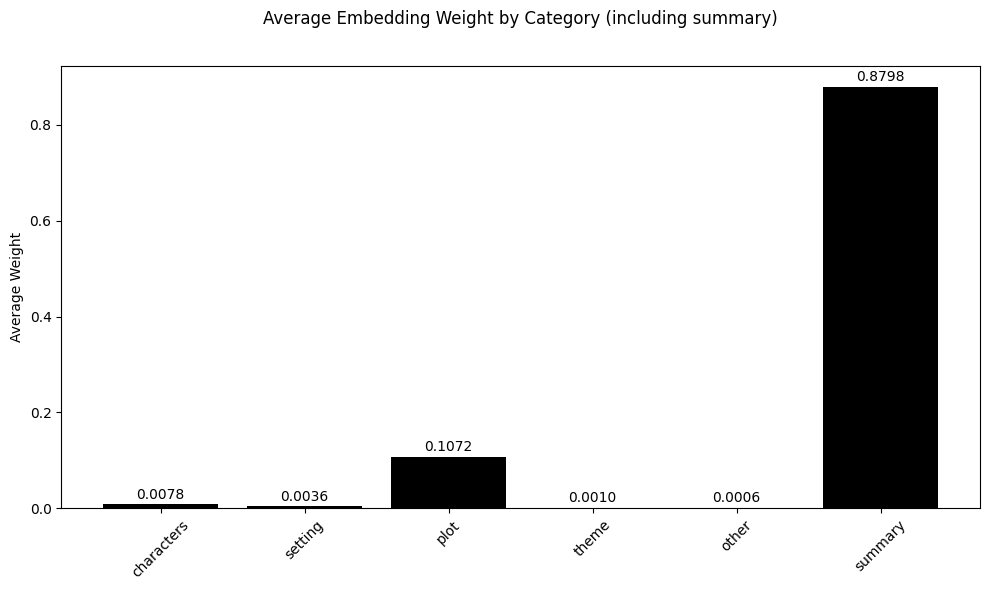

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data
contributions = np.array([7.7531e-03,3.5982e-03, 1.0718e-01, 1.0423e-03, 6.0177e-04,8.7982e-01])
categories = ["embedding_characters", "embedding_setting", "embedding_plot", 
              "embedding_theme", "embedding_other", "embedding_summary"]
cleaned_labels = [label.replace("embedding_", "") for label in categories]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cleaned_labels, contributions, color='black')
plt.ylabel('Average Weight')
plt.title('Average Embedding Weight by Category (including summary)', pad=30)  # More padding above title
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height+  0.005, f'{height:.4f}',
             ha='center', va='bottom', color = 'black')

# Manually set top margin to avoid clipping
#plt.subplots_adjust(top=0.8)  # Lower value means more space at top
plt.tight_layout()
plt.savefig("../../images/embedding_weight_1.png", bbox_inches='tight')

plt.show()
